In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
import missingno as msno
import plotly.express as px
import plotting_utils
from constant import MAP_TIME_COL, NODE_TO_PARTITION_NAME
from utils import get_idle_proportion

In [19]:
"""" 
We would like to motivate the subject in terms of the impacts that it can have.
For doing so we find the the power that a node uses, while it is idle.
"""

'" \nWe would like to motivate the subject in terms of the impacts that it can have.\nFor doing so we find the the power that a node uses, while it is idle.\n'

In [20]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_prom_data = Path('/projects/2/prjs1098/system_analytics_2024/prom_data')
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_EDA_cleaned.parquet.gzip')
df.sample(n=5)

,node,time,state,node_type,time_30min_interval,time_1hour_interval,time_2hour_interval,time_3hour_interval,time_6hour_interval,time_12hour_interval,time_day_interval
226,tcn522,2024-11-22 14:56:58,idle,tcn,2024-11-22 14:30:00,2024-11-22 14:00:00,2024-11-22 14:00:00,2024-11-22 12:00:00,2024-11-22 12:00:00,2024-11-22 12:00:00,2024-11-22
329,tcn1150,2024-11-09 19:09:42,idle,tcn,2024-11-09 19:00:00,2024-11-09 19:00:00,2024-11-09 18:00:00,2024-11-09 18:00:00,2024-11-09 18:00:00,2024-11-09 12:00:00,2024-11-09
5,gcn109,2024-11-11 06:40:27,mixed,gcn,2024-11-11 06:30:00,2024-11-11 06:00:00,2024-11-11 06:00:00,2024-11-11 06:00:00,2024-11-11 06:00:00,2024-11-11 00:00:00,2024-11-11
38,tcn94,2024-11-22 08:02:17,allocated,tcn,2024-11-22 08:00:00,2024-11-22 08:00:00,2024-11-22 08:00:00,2024-11-22 06:00:00,2024-11-22 06:00:00,2024-11-22 00:00:00,2024-11-22
6,gcn21,2024-11-13 14:13:17,allocated,gcn,2024-11-13 14:00:00,2024-11-13 14:00:00,2024-11-13 14:00:00,2024-11-13 12:00:00,2024-11-13 12:00:00,2024-11-13 12:00:00,2024-11-13


In [21]:
""" 
We need to add a column for idle power, meaning how much power a node uses in an hour when it is in idle mode?

node name      idle_power_usage
 node_1           100W
 node_2            120W 
How to get this data? since they seem to depend only on the node hardware.
Two solutions:
1) Ask experts==> No time
2) Use prom data and figure this out ==> we select this soultion.

"""
time_col = 'time_1hour_interval'
# ensure that it is idle at leat this amount of time
idle_duration_time = MAP_TIME_COL[time_col] * 0.98
df_stat, _, _ = get_idle_proportion(df, time_col)

# exact idle to only consider the power that was used during this duration
mask_high_idle = ((df_stat['idle_duration'] >= (idle_duration_time)) &
                                        ((df_stat['idle_proportion'] == 1)))

df_stat_1hour_idle = df_stat[mask_high_idle].copy()
display(df_stat_1hour_idle.sample(n=5))
print(f"Number of node-hour being idle: {len(df_stat_1hour_idle)}")
print(f"Number of unique idle nodes: {df_stat_1hour_idle['node'].nunique()}")
print(df_stat_1hour_idle['node'].value_counts())
# some of the nodes only have one record, some of them  don't. 
# with getting more and more data these problems might go away because the chance is
# they become idle.

,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion
48061,fcn88,2024-11-14 09:00:00,0 days 00:59:06,0 days 00:59:06,1.0
553440,tcn729,2024-11-06 23:00:00,0 days 00:59:43,0 days 00:59:43,1.0
234120,tcn1219,2024-11-18 20:00:00,0 days 00:59:03,0 days 00:59:03,1.0
32204,fcn56,2024-11-05 13:00:00,0 days 00:59:17,0 days 00:59:17,1.0
189469,tcn1129,2024-11-20 21:00:00,0 days 00:58:55,0 days 00:58:55,1.0


Number of node-hour being idle: 170351
Number of unique idle nodes: 1478
node
fcn118     317
fcn119     317
fcn120     317
fcn111     317
fcn112     317
fcn114     317
fcn116     317
fcn115     317
fcn113     317
fcn117     317
tcn1076    316
tcn1078    316
tcn1077    316
tcn1079    316
tcn1093    316
tcn1080    316
tcn1101    316
tcn1100    316
tcn1081    316
tcn1098    316
tcn1097    316
tcn1096    316
tcn1099    316
tcn1095    316
tcn1086    316
tcn1088    316
tcn1087    316
tcn1089    316
tcn1090    316
tcn1091    316
tcn1092    316
tcn1085    316
tcn1084    316
tcn1083    316
tcn1082    316
tcn1075    316
tcn1074    316
tcn1094    316
tcn1072    316
tcn1073    316
tcn1070    316
tcn1071    316
tcn1055    315
tcn1051    315
tcn1053    315
tcn1054    315
tcn1069    315
tcn1057    315
tcn1045    315
tcn1046    315
tcn1192    315
tcn1044    315
tcn1210    315
tcn1042    315
tcn1043    315
tcn1048    315
tcn1049    315
tcn1050    315
tcn1047    315
tcn1041    315
tcn1040    315
tcn1039

In [22]:
"""
Get the prom data for this rows and do average for each node.  
Then for each node you get 1 number that says how much power is used when the node is idle for 1 hour.
we check if similar nodes actually have the same power usage when they are idle
left merge this with the df_stat that we have based on the node only."""


# use up-to-date prom data
df_prom_average = pd.read_parquet(folder_path_prom_data /'average_signal_prom'/'prom_average_data.parquet.gzip')
# merge the data with the df_stat
df_stat_1hour_idle = pd.merge(df_stat_1hour_idle, df_prom_average,
                   how='left', left_on=['node', 'time_1hour_interval'], 
                   right_on=['node', 'time']).copy()

display(df_stat_1hour_idle.head(), df_prom_average.head(), df_stat_1hour_idle['idle_duration'].describe())

,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,time,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_memory_Active_bytes_max,node_memory_Active_bytes_mean,node_memory_Active_bytes_median,node_memory_Dirty_bytes_min,node_memory_Dirty_bytes_max,node_memory_Dirty_bytes_mean,node_memory_Dirty_bytes_median,node_memory_MemAvailable_bytes_min,node_memory_MemAvailable_bytes_max,node_memory_MemAvailable_bytes_mean,node_memory_MemAvailable_bytes_median,node_memory_MemFree_bytes_min,node_memory_MemFree_bytes_max,node_memory_MemFree_bytes_mean,node_memory_MemFree_bytes_median,node_memory_MemTotal_bytes_min,node_memory_MemTotal_bytes_max,node_memory_MemTotal_bytes_mean,node_memory_MemTotal_bytes_median,node_memory_Percpu_bytes_min,node_memory_Percpu_bytes_max,node_memory_Percpu_bytes_mean,node_memory_Percpu_bytes_median,node_netstat_Icmp_InErrors_min,node_netstat_Icmp_InErrors_max,node_netstat_Icmp_InErrors_mean,node_netstat_Icmp_InErrors_median,node_netstat_Icmp_InMsgs_min,node_netstat_Icmp_InMsgs_max,node_netstat_Icmp_InMsgs_mean,node_netstat_Icmp_InMsgs_median,node_netstat_Icmp_OutMsgs_min,node_netstat_Icmp_OutMsgs_max,node_netstat_Icmp_OutMsgs_mean,node_netstat_Icmp_OutMsgs_median,node_netstat_Tcp_InErrs_min

,node,time,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_memory_Active_bytes_max,node_memory_Active_bytes_mean,node_memory_Active_bytes_median,node_memory_Dirty_bytes_min,node_memory_Dirty_bytes_max,node_memory_Dirty_bytes_mean,node_memory_Dirty_bytes_median,node_memory_MemAvailable_bytes_min,node_memory_MemAvailable_bytes_max,node_memory_MemAvailable_bytes_mean,node_memory_MemAvailable_bytes_median,node_memory_MemFree_bytes_min,node_memory_MemFree_bytes_max,node_memory_MemFree_bytes_mean,node_memory_MemFree_bytes_median,node_memory_MemTotal_bytes_min,node_memory_MemTotal_bytes_max,node_memory_MemTotal_bytes_mean,node_memory_MemTotal_bytes_median,node_memory_Percpu_bytes_min,node_memory_Percpu_bytes_max,node_memory_Percpu_bytes_mean,node_memory_Percpu_bytes_median,node_netstat_Icmp_InErrors_min,node_netstat_Icmp_InErrors_max,node_netstat_Icmp_InErrors_mean,node_netstat_Icmp_InErrors_median,node_netstat_Icmp_InMsgs_min,node_netstat_Icmp_InMsgs_max,node_netstat_Icmp_InMsgs_mean,node_netstat_Icmp_InMsgs_median,node_netstat_Icmp_OutMsgs_min,node_netstat_Icmp_OutMsgs_max,node_netstat_Icmp_OutMsgs_mean,node_netstat_Icmp_OutMsgs_median,node_netstat_Tcp_InErrs_min,node_netstat_Tcp_InErrs_max,node_netstat_Tcp_InErrs_mean,node_netstat_Tcp_InErrs_

count                       170351
mean     0 days 00:59:19.204331057
std      0 days 00:00:17.265365050
min                0 days 00:58:49
25%                0 days 00:59:06
50%                0 days 00:59:14
75%                0 days 00:59:38
max                0 days 00:59:57
Name: idle_duration, dtype: object

In [23]:
# good signals that we want to pick from the data set
node_time_signals = ['node', 'time', 'idle_duration','all_state_durations_in_interval',	'idle_proportion'] 
surf_power_signals = ['surf_cpu_power_mean', 'surf_sys_power_mean', 'surf_gpu_board_power_mean', 
                      'surf_mem_power_mean']

# make sure that no power is nan, we remove them, by getting more data from prom,
# the number of these row decreases
mask = df_stat_1hour_idle['surf_sys_power_mean'].isna()
df_idle_1hour_power_signals = (df_stat_1hour_idle[~mask])[node_time_signals + surf_power_signals].copy()


# get the average power for each node
df_idle_power_average = df_idle_1hour_power_signals.groupby('node', as_index=False)[['surf_cpu_power_mean','surf_sys_power_mean', 
                                               'surf_mem_power_mean','surf_gpu_board_power_mean']].mean(numeric_only=True)


In [24]:
display(df_idle_1hour_power_signals.sample(n=10), df_idle_power_average.sample(n=10), 
                    df_idle_power_average.describe())

,node,time,idle_duration,all_state_durations_in_interval,idle_proportion,surf_cpu_power_mean,surf_sys_power_mean,surf_gpu_board_power_mean,surf_mem_power_mean
31301,gcn65,2024-11-06 06:00:00,0 days 00:59:08,0 days 00:59:08,1.0,240.0000,580.0000,220.0,25.0000
115367,tcn598,2024-11-05 05:00:00,0 days 00:59:19,0 days 00:59:19,1.0,58.5417,177.5833,NaN,4.5333
32006,hcn3,2024-11-10 06:00:00,0 days 00:59:30,0 days 00:59:30,1.0,158.9000,633.3333,NaN,NaN
57962,tcn1086,2024-11-11 01:00:00,0 days 00:59:43,0 days 00:59:43,1.0,60.6667,179.0833,NaN,6.8000
83792,tcn1223,2024-11-05 21:00:00,0 days 00:59:37,0 days 00:59:37,1.0,67.9167,213.5000,NaN,3.8000
66027,tcn1123,2024-11-09 00:00:00,0 days 00:59:11,0 days 00:59:11,1.0,65.1667,221.3333,NaN,5.8500
123692,tcn739,2024-11-09 11:00:00,0 days 00:59:44,0 days 00:59:44,1.0,55.4583,221.9167,NaN,5.1625
89833,tcn1243,2024-11-12 14:00:00,0 days 00:59:04,0 days 00:59:04,1.0,60.1250,219.0000,NaN,5.8708
149896,tcn890,2024-11-07 06:00:00,0 days 00:59:37,0 days 00:59:37,1.0,60.6667,172.5000,NaN,3.6000
19431,fcn68,2024-11-10 00:00:00,0 days 00:59:10,0 days 00:59:10,1.0,177.3333,332.2500,NaN,NaN


,node,surf_cpu_power_mean,surf_sys_power_mean,surf_mem_power_mean,surf_gpu_board_power_mean
1032,tcn811,64.9352,224.2870,4.4685,NaN
272,tcn1035,57.5076,214.3713,5.0850,NaN
142,gcn123,210.7879,714.3106,25.9939,400.0
1026,tcn806,65.6775,192.7572,5.6317,NaN
29,fcn17,175.9009,340.9890,NaN,NaN
589,tcn265,178.5167,299.8438,NaN,NaN
929,tcn695,66.2259,218.3553,4.9947,NaN
457,tcn1221,67.5503,218.6854,5.6241,NaN
1089,tcn868,56.8743,169.0718,5.3487,NaN
413,tcn1165,59.2008,218.2575,5.1969,NaN


,surf_cpu_power_mean,surf_sys_power_mean,surf_mem_power_mean,surf_gpu_board_power_mean
count,1227.0000,1227.0000,843.0000,115.0000
mean,116.1847,284.6420,8.7904,336.2583
std,65.2459,141.8586,7.4561,121.6012
min,40.0000,159.4635,1.0000,179.6983
25%,60.5642,199.3026,5.0660,227.8533
50%,70.5238,229.0370,5.6911,305.3125
75%,175.1292,299.8824,7.1122,420.0000
max,349.3750,1230.8333,31.3444,879.0833


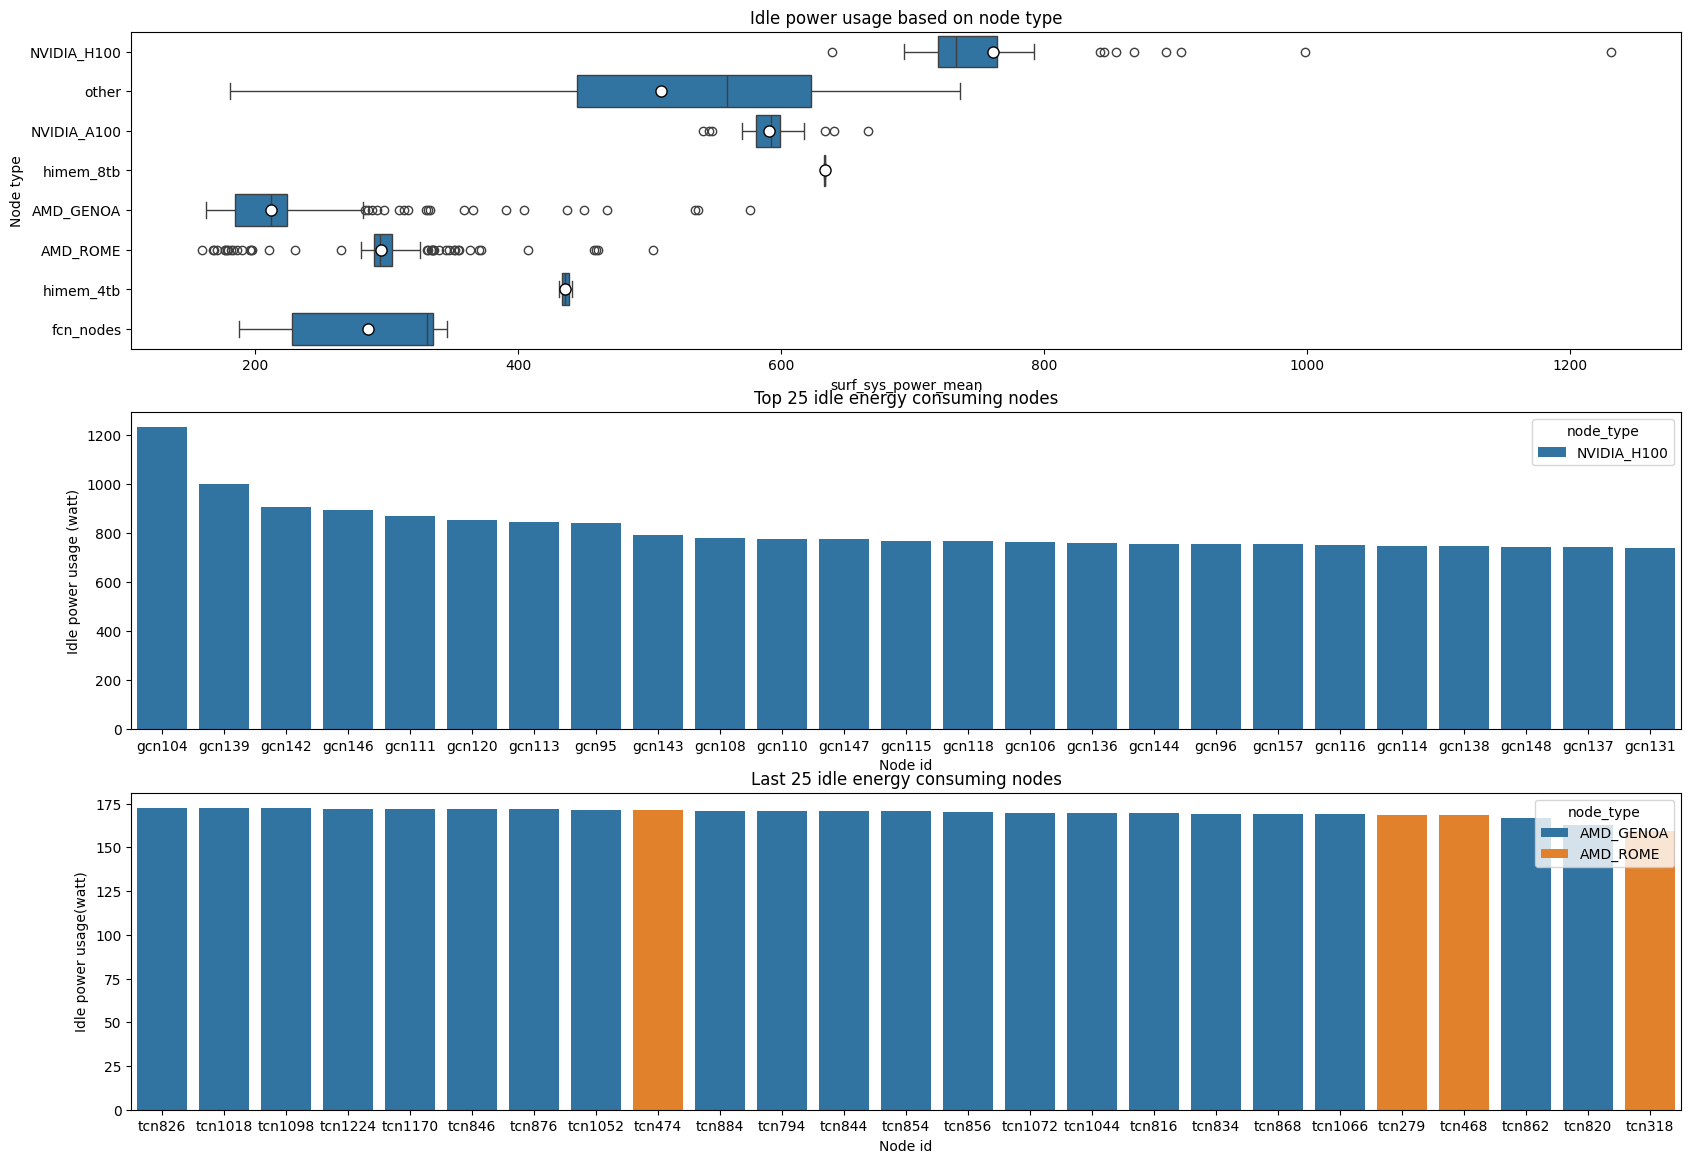

In [25]:
"""  
We show the distribution for idle power usage. ==> I expect by getting more and more data from 
Promethues we get better values for the power usages.
What are the nodes that consume more energy if they are idle? 
What are the idle power usage per partitions.
"""

df_temp = df_idle_power_average.copy()
df_temp.sort_values(['surf_sys_power_mean'], inplace=True, ascending=False)
df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))




fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 14))

sns.boxplot(df_temp, x='surf_sys_power_mean', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
sns.barplot(df_temp.iloc[0:25], x='node', y='surf_sys_power_mean', hue='node_type', ax=ax[1])
sns.barplot(df_temp.iloc[-25:], x='node', y='surf_sys_power_mean', hue='node_type', ax=ax[2])


ax[0].set_ylabel("Node type")
ax[0].set_title("Idle power usage based on node type")

ax[1].set_title("Top 25 idle energy consuming nodes")
ax[1].set_ylabel("Idle power usage (watt)")
ax[1].set_xlabel('Node id')

ax[2].set_title("Last 25 idle energy consuming nodes")
ax[2].set_ylabel("Idle power usage(watt)")
ax[2].set_xlabel("Node id")
plt.show()




In [26]:
"""   
PLEASE READ CAREFULLY:


We measaure the idle duration for the nodes by selecting a predefined resultion.
This allows us to gracefully treat being idle for further analysis. 
The reason is we cannot use 1 hour idle and argue that the energy used in this time was wasted
because a counter argunmnet might say we cannot shut down a node for 1 hour.
"""

time_col = 'time_3hour_interval'

# minimum time to be idle to be counted as idle
min_idle_duration_time = MAP_TIME_COL[time_col] * 0.98
df_stat, _, _ = get_idle_proportion(df, time_col)

# exact idle to only consider the power that was used dusing this duration
mask_high_idle = ((df_stat['idle_duration'] >= (min_idle_duration_time)) &
                                        ((df_stat['idle_proportion'] == 1)))
# we only select the rows that are 100 percent idle and it took more than idle_duration_min
df_stat_highly_idle = df_stat[mask_high_idle].copy()


# turn the idle duration to hour
df_stat_highly_idle['idle_duration_hour'] = (df_stat_highly_idle['idle_duration']
                                                                                .dt.total_seconds()/3600)
display(df_stat_highly_idle.head())


,node,time_3hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,idle_duration_hour
38,fcn1,2024-11-09 09:00:00,0 days 02:59:30,0 days 02:59:30,1.0,2.9917
39,fcn1,2024-11-09 12:00:00,0 days 02:59:17,0 days 02:59:17,1.0,2.9881
40,fcn1,2024-11-09 15:00:00,0 days 02:59:42,0 days 02:59:42,1.0,2.9950
41,fcn1,2024-11-09 18:00:00,0 days 02:59:36,0 days 02:59:36,1.0,2.9933
42,fcn1,2024-11-09 21:00:00,0 days 02:59:34,0 days 02:59:34,1.0,2.9928


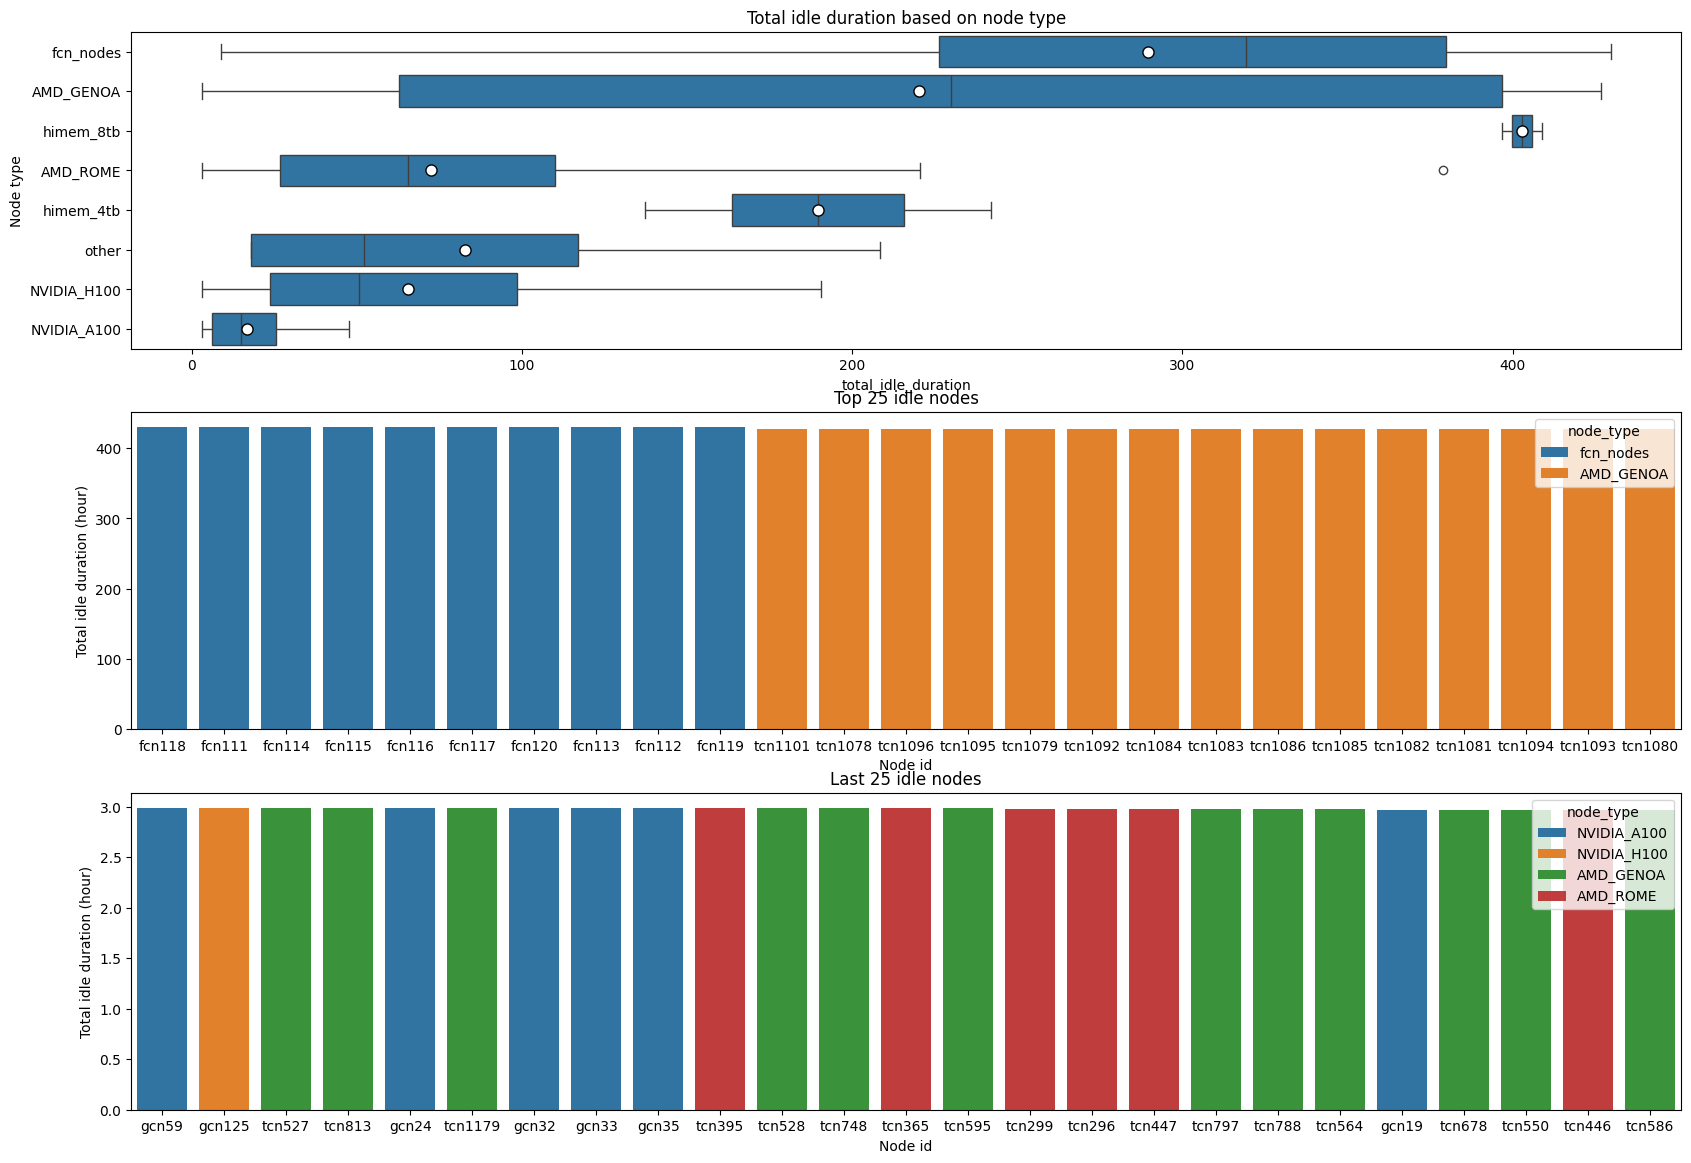

In [27]:
# plotting
df_temp = df_stat_highly_idle.groupby('node', as_index=False)['idle_duration_hour'].sum()
df_temp.rename(columns={'idle_duration_hour': 'total_idle_duration'}, inplace=True)
df_temp.sort_values(['total_idle_duration'], inplace=True, ascending=False)
df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))



fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 14))

sns.boxplot(df_temp, x='total_idle_duration', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
sns.barplot(df_temp.iloc[0:25], x='node', y='total_idle_duration', hue='node_type', ax=ax[1])
sns.barplot(df_temp.iloc[-25:], x='node', y='total_idle_duration', hue='node_type', ax=ax[2])


ax[0].set_ylabel("Node type")
ax[0].set_title("Total idle duration based on node type")

ax[1].set_title("Top 25 idle nodes")
ax[1].set_ylabel("Total idle duration (hour)")
ax[1].set_xlabel('Node id')

ax[2].set_title("Last 25 idle nodes")
ax[2].set_ylabel("Total idle duration (hour)")
ax[2].set_xlabel("Node id")
plt.show()





In [28]:
"""  
We compute energy consumption for the idle nodes, for doing so we use the data farme
that shows the amount of power useage for each idle node.
"""
KILO_WAT_CONVERSION = 1000

# do the left join with df_idle_power_average
df_high_idle_with_average_power = pd.merge(left=df_stat_highly_idle, right=df_idle_power_average, 
              how='left', on='node')

# use surf sys power and compute the idle kilo wat hour
df_high_idle_with_average_power['idle_kilo_watt_hour'] = (df_high_idle_with_average_power['idle_duration_hour']
                                                         .multiply(df_high_idle_with_average_power['surf_sys_power_mean']
                                                                   /KILO_WAT_CONVERSION, fill_value=0))
display(df_stat_highly_idle.sample(n=10), df_high_idle_with_average_power.sample(n=10))

,node,time_3hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,idle_duration_hour
76032,tcn1203,2024-11-21 03:00:00,0 days 02:58:25,0 days 02:58:25,1.0,2.9736
198209,tcn803,2024-11-12 00:00:00,0 days 02:58:13,0 days 02:58:13,1.0,2.9703
205077,tcn845,2024-11-08 00:00:00,0 days 02:59:33,0 days 02:59:33,1.0,2.9925
174395,tcn660,2024-11-16 12:00:00,0 days 02:58:18,0 days 02:58:18,1.0,2.9717
228050,tcn983,2024-11-10 21:00:00,0 days 02:59:27,0 days 02:59:27,1.0,2.9908
143831,tcn476,2024-11-21 00:00:00,0 days 02:58:44,0 days 02:58:44,1.0,2.9789
219709,tcn932,2024-11-18 06:00:00,0 days 02:58:17,0 days 02:58:17,1.0,2.9714
230477,tcn998,2024-11-14 06:00:00,0 days 02:58:16,0 days 02:58:16,1.0,2.9711
291,fcn10,2024-11-22 06:00:00,0 days 02:59:09,0 days 02:59:09,1.0,2.9858
5513,fcn23,2024-11-18 18:00:00,0 days 02:57:29,0 days 02:57:29,1.0,2.9581


,node,time_3hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,idle_duration_hour,surf_cpu_power_mean,surf_sys_power_mean,surf_mem_power_mean,surf_gpu_board_power_mean,idle_kilo_watt_hour
58873,tcn799,2024-11-11 03:00:00,0 days 02:59:22,0 days 02:59:22,1.0,2.9894,62.1962,216.0430,5.5211,NaN,0.6458
1275,fcn107,2024-11-21 12:00:00,0 days 02:58:25,0 days 02:58:25,1.0,2.9736,58.1787,200.1475,9.4963,NaN,0.5952
62792,tcn839,2024-11-08 15:00:00,0 days 02:59:42,0 days 02:59:42,1.0,2.9950,57.0256,215.2346,5.7528,NaN,0.6446
11966,gcn122,2024-11-17 21:00:00,0 days 02:57:26,0 days 02:57:26,1.0,2.9572,220.0000,714.2222,25.8884,399.5556,2.1121
30786,tcn1148,2024-11-20 03:00:00,0 days 02:58:48,0 days 02:58:48,1.0,2.9800,63.3523,194.1997,6.3948,NaN,0.5787
115,fcn10,2024-11-13 15:00:00,0 days 02:59:19,0 days 02:59:19,1.0,2.9886,176.0553,333.4799,NaN,NaN,0.9966
24843,tcn1085,2024-11-22 18:00:00,0 days 02:58:27,0 days 02:58:27,1.0,2.9742,59.0264,209.4619,3.3555,NaN,0.6230
63121,tcn841,2024-11-18 15:00:00,0 days 02:58:21,0 days 02:58:21,1.0,2.9725,58.9006,216.1077,5.7139,NaN,0.6424
32225,tcn1166,2024-11-16 18:00:00,0 days 02:58:50,0 days 02:58:50,1.0,2.9806,63.4225,182.9506,5.3424,NaN,0.5453
37653,tcn1226,2024-11-19 18:00:00,0 days 02:58:37,0 days 02:58:37,1.0,2.9769,58.1102,173.0259,3.2875,NaN,0.5151


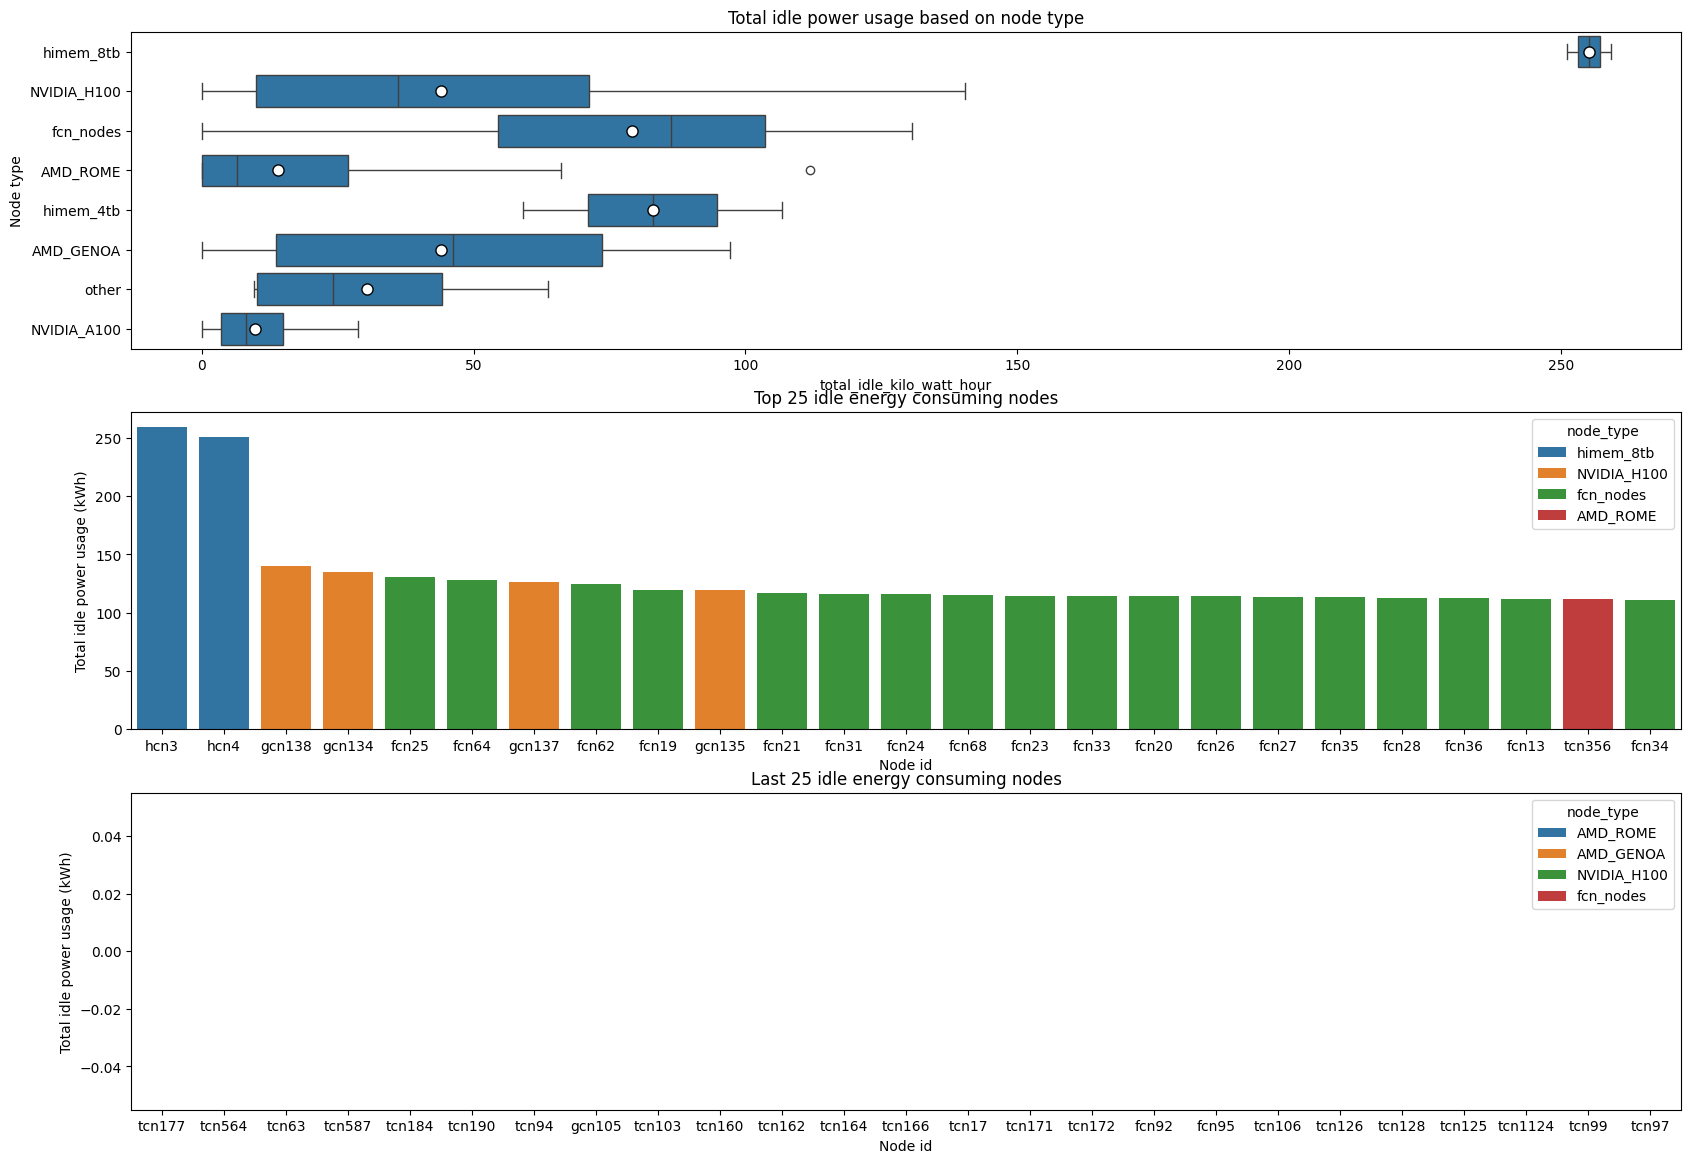

In [29]:
# plotting

df_temp = df_high_idle_with_average_power.groupby('node', as_index=False)['idle_kilo_watt_hour'].sum()
df_temp.rename(columns={'idle_kilo_watt_hour': 'total_idle_kilo_watt_hour'}, inplace=True)
df_temp.sort_values(['total_idle_kilo_watt_hour'], inplace=True, ascending=False)
df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 14))

sns.boxplot(df_temp, x='total_idle_kilo_watt_hour', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
sns.barplot(df_temp.iloc[0:25], x='node', y='total_idle_kilo_watt_hour', hue='node_type', ax=ax[1])
sns.barplot(df_temp.iloc[-25:], x='node', y='total_idle_kilo_watt_hour', hue='node_type', ax=ax[2])


ax[0].set_ylabel("Node type")
ax[0].set_title("Total idle power usage based on node type")

ax[1].set_title("Top 25 idle energy consuming nodes")
ax[1].set_ylabel("Total idle power usage (kWh)")
ax[1].set_xlabel('Node id')

ax[2].set_title("Last 25 idle energy consuming nodes")
ax[2].set_ylabel("Total idle power usage (kWh)")
ax[2].set_xlabel("Node id")
plt.show()




In [30]:
"""  
What is the source of the electricity price?
We get the price for electricity for the following website. They report the data from
CBS which is the central organziation for statistic in the Netherlands.
We guess that the price can be lower for major consumers.
For this reason we also divide the price by 3. 
"""
from IPython.display import HTML

# Embed iframe with custom styling
HTML("""
<iframe title="Grafiek gemiddelde stroomprijs per kWh t/m sept 2024"
        aria-label="Interactive line chart"
        id="datawrapper-chart-b9Uc0"
        src="https://datawrapper.dwcdn.net/b9Uc0/21/"
        scrolling="no"
        frameborder="0"
        style="width: 100%; min-width: 100% !important; border: none; background-color: #f4f4f9;"
        height="662"
        data-external="1"></iframe>
""")


In [31]:
# price for electricity per kilo wat hour
ELEC_PRICE_KWH = 0.30
# CO2 emmission kg per kWh, we use the data from
# reference: https://www.cbs.nl/nl-nl/achtergrond/2023/51/rendementen-en-co2-emissie-van-elektriciteitsproductie-in-nederland-update-2022
CO2_EMISSION = 0.27


# compute the price for the kilo-wat hour
df_high_idle_with_average_power['financial_cost'] = (df_high_idle_with_average_power['idle_kilo_watt_hour'] 
                                                                                         * ELEC_PRICE_KWH)
# add all the cost together
total_financial_cost = df_high_idle_with_average_power['financial_cost'].sum()

# compute Co2 emission for kilo-watt hour
df_high_idle_with_average_power['co2_emission'] = (df_high_idle_with_average_power['idle_kilo_watt_hour'] 
                                                                                         * CO2_EMISSION)
# add all the emssion together
total_co2_emission = df_high_idle_with_average_power['co2_emission'].sum()

# add all the idle duration and energy usages together
total_year_idle = (df_high_idle_with_average_power['idle_duration_hour'].sum())/ (24 * 365)
total_power_idle = (df_high_idle_with_average_power['surf_sys_power_mean'].sum())/KILO_WAT_CONVERSION

print(f"Total financial cost occured due to idle nodes: {total_financial_cost} Euro")
print(f"Total amount of CO2 emission occured due to idle nodes: {total_co2_emission} kg CO2")


Total financial cost occured due to idle nodes: 15491.749761918683 Euro
Total amount of CO2 emission occured due to idle nodes: 13942.574785726818 kg CO2


In [32]:
df_temp = df_high_idle_with_average_power[['node', 'idle_duration_hour','surf_sys_power_mean',
                                           'financial_cost', 'co2_emission']].copy()
# df_temp['normalized_financial_cost'] = df_temp['financial_cost']/total_financial_cost
# df_temp['normalized_co2_emission'] = df_temp['co2_emission']/total_co2_emission
df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))
# df_stat_fin_co2_cost = df_temp.groupby('node_type', as_index=False)[['normalized_financial_cost', 
#                                                                      'normalized_co2_emission']].sum()


df_stat_fin_co2_cost = df_temp.groupby('node_type', as_index=False)[['idle_duration_hour', 'surf_sys_power_mean',
                                                                     'financial_cost','co2_emission']].sum()
df_stat_fin_co2_cost

,node_type,idle_duration_hour,surf_sys_power_mean,financial_cost,co2_emission
0,AMD_GENOA,154921.5381,1.0369e+07,9281.3757,8353.2382
1,AMD_ROME,36472.5494,2.3635e+06,2111.0572,1899.9515
2,NVIDIA_A100,853.8317,1.6702e+05,149.5878,134.6291
3,NVIDIA_H100,4249.0367,9.6022e+05,858.3355,772.5020
4,fcn_nodes,34744.2214,3.1860e+06,2852.1226,2566.9103
5,himem_4tb,379.2972,5.5554e+04,49.7756,44.7980
6,himem_8tb,805.7544,1.7094e+05,153.0433,137.7389
7,other,330.7889,4.0750e+04,36.4521,32.8069


In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=2, cols=2,
                    specs=[[{'type': 'domain'}, {'type': 'domain'}],[{'type': 'domain'}, {'type': 'domain'}]], 
                    subplot_titles=[f'Total idle time: {total_year_idle:9.2f} years',
                                    f'Total idle power usage: {total_power_idle:9.2f} Kw',
                                    f'Total financial cost: {total_financial_cost:9.2f} Euro',
                                    f'Total  CO2 emission: {total_co2_emission:9.2f} Kg'])


# Add Pie charts
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["idle_duration_hour"],
        name="idle duration",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name

    ),
    1, 1
)
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["surf_sys_power_mean"],
        name="idle power usage",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name
    ),
    1, 2
)



# Add Pie charts
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["financial_cost"],
        name="Financial Cost",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name

    ),
    2, 2
)
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["co2_emission"],
        name="CO2 Emission",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name
    ),
    2, 1
)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="name+percent+label")

# Add annotations
fig.update_layout(height=600)
fig.show()

In [34]:
# We also need to get the power usage for those nodes that have nor appeared in prom yet.